# Gesture Recognition

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
!pip install scipy==1.2.1
!pip install keras
from scipy.misc import imread, imresize
import datetime
import matplotlib.pyplot as plt

     |████████████████████████████████| 24.8 MB 4.6 MB/s eta 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error

In [ ]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
batch_size = 32
sequence_idx = range(5,28,1)  # selecting alternate frames from 5 to 28.
dim_x, dim_y = 144, 144

In [ ]:
def generator(source_path, folder_list, batch_size, debug=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size, )
   
    img_idx = sequence_idx
    x = len(img_idx)
    y, z = dim_x, dim_y

    while True: ##  
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        
        """Let's take an example, assume we have 25 samples and we pick batch size as 10.
        In this case there will be 2 complete batches of ten each

        Batch 1: 10
        Batch 2: 10
        Batch 3: 5"""
        
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(18,5))
                
                if folder + (batch*batch_size) >= len(t): #Handling edge cases
                    break

                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder


                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))
                      
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    #Cropping Sides
                    height, width, channels = image.shape

                    if width > height:
                        diff_wh_px = width - height
                        crop_start = diff_wh_px//2
                        crop_end = crop_start + height
                        image = image[:, crop_start:crop_end]
                    elif height > width:
                        diff_hw_px = height - width
                        crop_start = diff_hw_px//2
                        crop_end = crop_start + width
                        image = image[:, crop_start:crop_end]
                    
                    resized_image = imresize(image, size=(y,z)) 

                    batch_data[folder,idx,:,:,0] = resized_image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = resized_image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = resized_image[:,:,2]/255

                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_image)

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
            ## The remaining frames were handled in the above code.

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = "datasets/Project_data/train"
val_path = 'datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


Source path =  datasets/Project_data/train ; batch size = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


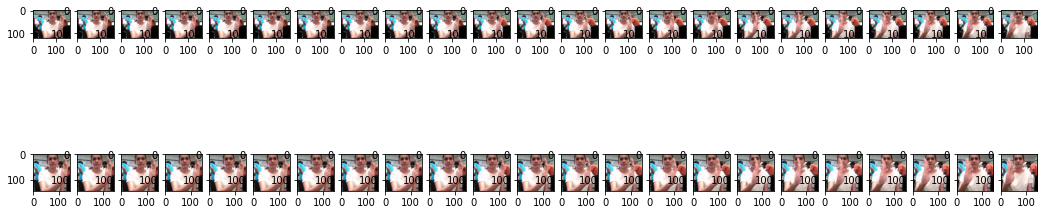

In [ ]:
# test generator 
tg = generator(train_path, train_doc, 1, debug = True)
d = next(tg)[0]

# Modelling

Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## 1.1) Conv3D Model

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
input_shape = (len(sequence_idx), dim_x, dim_y, 3)

In [ ]:
model = Sequential()
model.add(Conv3D(32, 3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(Conv3D(64, 3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))
model.add(Conv3D(128, 3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 21, 142, 142, 32)  2624      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 71, 71, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 69, 69, 64)     55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 34, 34, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 32, 32, 128)    221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 16, 16, 128)    0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
Source path =  datasets/Project_data/train ; batch size = 32


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.7182 - categorical_accuracy: 0.2798Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2021-06-2718_52_23.901543/model-00001-1.71821-0.27976-1.06835-0.46094.h5
21/21 [==============================] - 71s 3s/step - loss: 1.7182 - categorical_accuracy: 0.2798 - val_loss: 1.0683 - val_categorical_accuracy: 0.4609
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.1504 - categorical_accuracy: 0.5268
Epoch 00002: saving model to model_init_2021-06-2718_52_23.901543/model-00002-1.15038-0.52679-0.80066-0.48438.h5
21/21 [==============================] - 75s 4s/step - loss: 1.1504 - categorical_accuracy: 0.5268 - val_loss: 0.8007 - val_categorical_accuracy: 0.4844
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.7998 - categorical_accuracy: 0.6949
Epoch 00003: saving model to model_init_2021-06-2718_52_23.901543/model-00003-0.79981-0.694

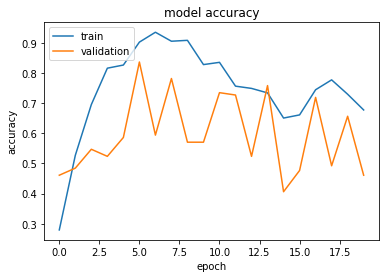

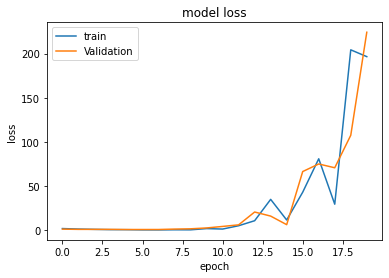

In [ ]:
## Plotting

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [1]:
### Number of Paramets 8,669,445
### Number of CNN Layers 3
### Model 3DCNN's
### Result
'''
Learns well for first 5 epochs, then accuracy drops.
Validation Loss increases in the last few epochs, model is starting to overfit

'''
### Decision + Explanation
'''
Changing the model architecture, will include same padding.
'''

'\nChanging the model architecture, will include same padding.\n'

## 1.2) Conv3D Model

In [ ]:
model = Sequential()
model.add(Conv3D(32, 3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, 3, activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Conv3D(128, 3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))
model.add(Conv3D(256, 3, activation='relu', ))
model.add(MaxPooling3D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 21, 142, 142, 32)  2624      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 21, 142, 142, 64)  55360     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 71, 71, 64)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 69, 69, 128)    221312    
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 4, 34, 34, 128)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 2, 32, 32, 256)    884992    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 1, 16, 16, 256)   

In [ ]:
model_name = 'model_1.2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
batch_size = 8
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.9538 - categorical_accuracy: 0.2262Source path =  datasets/Project_data/val ; batch size = 8

Epoch 00001: saving model to model_1.2_2021-06-2718_52_23.901543/model-00001-1.95376-0.22619-1.60718-0.25000.h5
21/21 [==============================] - 22s 1s/step - loss: 1.9538 - categorical_accuracy: 0.2262 - val_loss: 1.6072 - val_categorical_accuracy: 0.2500
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.6000 - categorical_accuracy: 0.2917
Epoch 00002: saving model to model_1.2_2021-06-2718_52_23.901543/model-00002-1.60001-0.29167-1.48273-0.34375.h5
21/21 [==============================] - 22s 1s/step - loss: 1.6000 - categorical_accuracy: 0.2917 - val_loss: 1.4827 - val_categorical_accuracy: 0.3438
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.4190 - categorical_accuracy: 0.3274
Epoch 00003: saving model to model_1.2_2021-06-2718_52_23.901543/model-00003-1.41902-0.32738-1

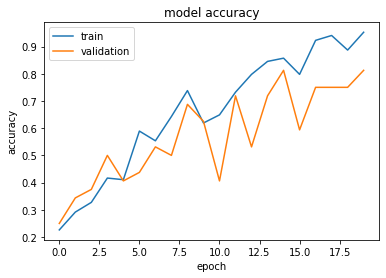

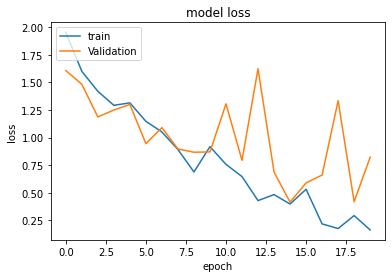

In [ ]:
## Plotting

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [2]:
### Number of Paramets 9,553,669
### Number of CNN Layers 4
### Model 3DCNN's
### Result
'''
Learns well for all the epochs.
Loss is decreasing gradually overall a good model.

'''
### Decision + Explanation
'''
Will try to further increase accuracy using different arch
'''

'\nWill try to further increase accuracy using different arch\n'

## 1.3) Conv3D Model

In [ ]:
model = Sequential()
model.add(Conv3D(32, 3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, 3, activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2,padding='same'))
model.add(Conv3D(128, 3, activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2,padding='same'))
model.add(Conv3D(256, 3, activation='relu',padding='same') )
model.add(MaxPooling3D(pool_size=2,padding='same'))
model.add(Conv3D(512, 3, activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2,padding='same'))
model.add(Conv3D(1024, 3, activation='relu',padding='same') )
model.add(MaxPooling3D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 21, 142, 142, 32)  2624      
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 21, 142, 142, 64)  55360     
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 11, 71, 71, 64)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 11, 71, 71, 128)   221312    
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 6, 36, 36, 128)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 6, 36, 36, 256)    884992    
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 3, 18, 18, 256)   

In [ ]:
model_name = 'model_1.3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
batch_size = 8
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.7722 - categorical_accuracy: 0.1964Source path =  datasets/Project_data/val ; batch size = 8

Epoch 00001: saving model to model_1.3_2021-06-2718_52_23.901543/model-00001-1.77220-0.19643-1.58399-0.21875.h5
21/21 [==============================] - 19s 918ms/step - loss: 1.7722 - categorical_accuracy: 0.1964 - val_loss: 1.5840 - val_categorical_accuracy: 0.2188
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5755 - categorical_accuracy: 0.2440
Epoch 00002: saving model to model_1.3_2021-06-2718_52_23.901543/model-00002-1.57552-0.24405-1.56493-0.37500.h5
21/21 [==============================] - 19s 928ms/step - loss: 1.5755 - categorical_accuracy: 0.2440 - val_loss: 1.5649 - val_categorical_accuracy: 0.3750
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.5468 - categorical_accuracy: 0.2738
Epoch 00003: saving model to model_1.3_2021-06-2718_52_23.901543/model-00003-1.54683-0.2

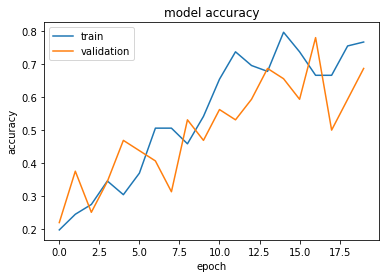

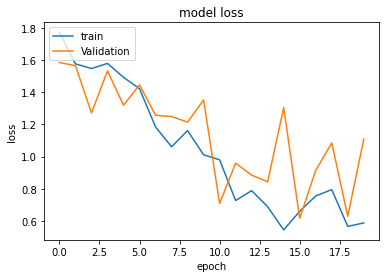

In [ ]:
## Plotting

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [3]:
### Number of Parameters 20,958,469
### Number of CNN Layers 6
### Model 3DCNN's
### Result
'''
Learns well for all the epochs.
Small sign of overfitting due to increased number or parameters

'''
### Decision + Explanation
'''
Will shift to RNN models now to capture the temporal data better.
'''

'\nWill shift to RNN models now to capture the temporal data better.\n'

## 2.1) Conv2D + GRU Model


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(144,144,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=input_shape))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 23, 64)            15239040  
_________________________________________________________________
gru (GRU)                    (None, 23, 32)            9408      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 45        
Total params: 15,251,029
Trainable params: 536,341
Non-trainable params: 14,714,688
____________________________________

In [ ]:
batch_size = 16
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6386 - categorical_accuracy: 0.1637Source path =  datasets/Project_data/val ; batch size = 16

Epoch 00001: saving model to model_init_2_2021-06-2718_52_23.901543/model-00001-1.63858-0.16369-1.59009-0.17188.h5
21/21 [==============================] - 46s 2s/step - loss: 1.6386 - categorical_accuracy: 0.1637 - val_loss: 1.5901 - val_categorical_accuracy: 0.1719
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5486 - categorical_accuracy: 0.2173
Epoch 00002: saving model to model_init_2_2021-06-2718_52_23.901543/model-00002-1.54863-0.21726-1.29466-0.37500.h5
21/21 [==============================] - 37s 2s/step - loss: 1.5486 - categorical_accuracy: 0.2173 - val_loss: 1.2947 - val_categorical_accuracy: 0.3750
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.6037 - categorical_accuracy: 0.2411
Epoch 00003: saving model to model_init_2_2021-06-2718_52_23.901543/model-00003-1.60371

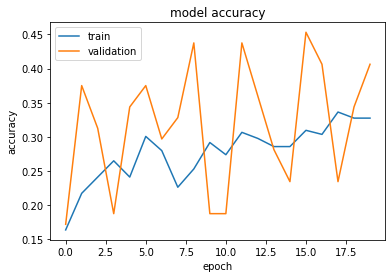

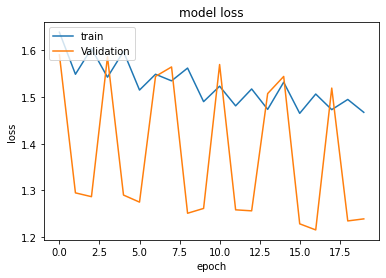

In [ ]:
## Plotting

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [5]:
### Number of Parameters 15,251,029
### Base : VGG
### Model CNN's + GRU
### Result
'''
Learning very slow needs a lot of training to converge.

'''
### Decision + Explanation
'''
Val loss is still oscillating a lot, will change the network params
'''

'\nVal loss is still oscillating a lot, will change the network params\n'

## 2.2) Conv2D + GRU Model

In [ ]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(144,144,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(256, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=input_shape))
model.add(GRU(32, return_sequences=True))
model.add(GRU(64, return_sequences=True))
model.add(GRU(128, return_sequences=True))
model.add(GRU(256))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 23, 256)           16812096  
_________________________________________________________________
gru_2 (GRU)                  (None, 23, 32)            27840     
_________________________________________________________________
gru_3 (GRU)                  (None, 23, 64)            18816     
_________________________________________________________________
gru_4 (GRU)                  (None, 23, 128)           74496     
_________________________________________________________________
gru_5 (GRU)                  (None, 256)               296448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)              

In [ ]:
batch_size = 16
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_2.1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6122 - categorical_accuracy: 0.1786Source path =  datasets/Project_data/val ; batch size = 16

Epoch 00001: saving model to model_init_2.1_2021-06-2718_52_23.901543/model-00001-1.61220-0.17857-1.61180-0.15625.h5
21/21 [==============================] - 39s 2s/step - loss: 1.6122 - categorical_accuracy: 0.1786 - val_loss: 1.6118 - val_categorical_accuracy: 0.1562
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5667 - categorical_accuracy: 0.2083
Epoch 00002: saving model to model_init_2.1_2021-06-2718_52_23.901543/model-00002-1.56671-0.20833-1.30821-0.12500.h5
21/21 [==============================] - 36s 2s/step - loss: 1.5667 - categorical_accuracy: 0.2083 - val_loss: 1.3082 - val_categorical_accuracy: 0.1250
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.6111 - categorical_accuracy: 0.1786
Epoch 00003: saving model to model_init_2.1_2021-06-2718_52_23.901543/model-00003-1

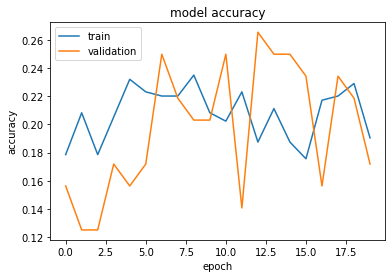

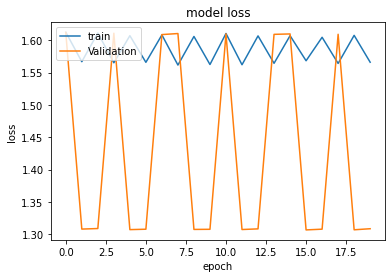

In [ ]:
## Plotting

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
### Number of Parameters 17,957,509
### Base : VGG
### Model CNN's + GRU
### Result
'''
Model performing worser because of vanishing gradient.

'''
### Decision + Explanation
'''
Will reduce GRU Layers and model complexity.
'''

## 2.3) Conv2D + GRU Model

In [ ]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(144,144,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(256, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=input_shape))
model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(512,))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 23, 256)           16812096  
_________________________________________________________________
gru_6 (GRU)                  (None, 23, 256)           394752    
_________________________________________________________________
dropout_4 (Dropout)          (None, 23, 256)           0         
_________________________________________________________________
gru_7 (GRU)                  (None, 512)               1182720   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)              

In [ ]:
batch_size = 16
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_2.2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6186 - categorical_accuracy: 0.1815Source path =  datasets/Project_data/val ; batch size = 16

Epoch 00001: saving model to model_init_2.2_2021-06-2718_52_23.901543/model-00001-1.61858-0.18155-1.60743-0.20312.h5
21/21 [==============================] - 38s 2s/step - loss: 1.6186 - categorical_accuracy: 0.1815 - val_loss: 1.6074 - val_categorical_accuracy: 0.2031
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5657 - categorical_accuracy: 0.2232
Epoch 00002: saving model to model_init_2.2_2021-06-2718_52_23.901543/model-00002-1.56568-0.22321-1.29964-0.25000.h5
21/21 [==============================] - 36s 2s/step - loss: 1.5657 - categorical_accuracy: 0.2232 - val_loss: 1.2996 - val_categorical_accuracy: 0.2500
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.6172 - categorical_accuracy: 0.1667
Epoch 00003: saving model to model_init_2.2_2021-06-2718_52_23.901543/model-00003-1

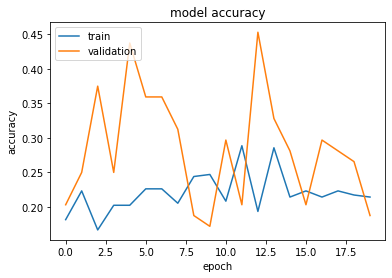

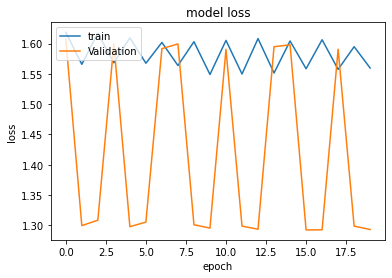

In [ ]:
## Plotting

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [6]:
### Number of Parameters 19,182,917
### Base : VGG
### Model CNN's + GRU
### Result
'''
Model performing better than all GRU models.

'''
### Decision + Explanation
'''
Model still not converging will try LSTM instead of GRU.
'''

'\nModel still not converging will try LSTM instead of GRU.\n'

## 3.1) Conv2D + LSTM Model

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed,LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(dim_x,dim_y,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(len(sequence_idx),dim_x,dim_y,3)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 23, 64)            15239040  
_________________________________________________________________
lstm (LSTM)                  (None, 23, 32)            12416     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 45        
Total params: 15,254,773
Trainable params: 540,085
Non-trainable params: 14,714,688
____________________________________

In [ ]:
batch_size = 16
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_3.1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6116 - categorical_accuracy: 0.2321Source path =  datasets/Project_data/val ; batch size = 16

Epoch 00001: saving model to model_init_3.1_2021-06-2718_52_23.901543/model-00001-1.61162-0.23214-1.59741-0.26562.h5
21/21 [==============================] - 38s 2s/step - loss: 1.6116 - categorical_accuracy: 0.2321 - val_loss: 1.5974 - val_categorical_accuracy: 0.2656
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5773 - categorical_accuracy: 0.1875
Epoch 00002: saving model to model_init_3.1_2021-06-2718_52_23.901543/model-00002-1.57729-0.18750-1.30057-0.34375.h5
21/21 [==============================] - 36s 2s/step - loss: 1.5773 - categorical_accuracy: 0.1875 - val_loss: 1.3006 - val_categorical_accuracy: 0.3438
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.5934 - categorical_accuracy: 0.2440
Epoch 00003: saving model to model_init_3.1_2021-06-2718_52_23.901543/model-00003-1

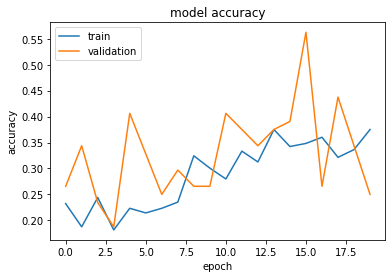

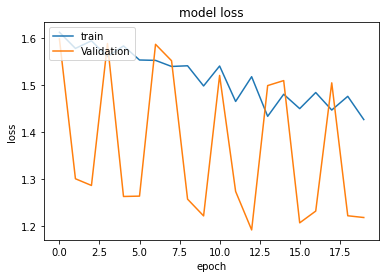

In [ ]:
## Plotting

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
### Number of Parameters 15,254,773
### Base : VGG
### Model CNN's + LSTM
### Result
'''
Model performing very poorly and it is severly underfit.

'''
### Decision + Explanation
'''
Model still not converging will try add more layers and reduce the dropout rate.
'''

## 3.2) Conv2D + LSTM Model

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed,LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(dim_x,dim_y,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(1024, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(len(sequence_idx),dim_x,dim_y,3)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 23, 1024)          23104320  
_________________________________________________________________
lstm_2 (LSTM)                (None, 23, 32)            135296    
_________________________________________________________________
lstm_3 (LSTM)                (None, 23, 64)            24832     
_________________________________________________________________
lstm_4 (LSTM)                (None, 23, 128)           98816     
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)              

In [ ]:
batch_size = 8
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_3.2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6071 - categorical_accuracy: 0.1726Source path =  datasets/Project_data/val ; batch size = 8

Epoch 00001: saving model to model_init_3.2_2021-06-2718_52_23.901543/model-00001-1.60715-0.17262-1.60947-0.18750.h5
21/21 [==============================] - 19s 926ms/step - loss: 1.6071 - categorical_accuracy: 0.1726 - val_loss: 1.6095 - val_categorical_accuracy: 0.1875
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.6108 - categorical_accuracy: 0.2083
Epoch 00002: saving model to model_init_3.2_2021-06-2718_52_23.901543/model-00002-1.61079-0.20833-1.60998-0.25000.h5
21/21 [==============================] - 19s 915ms/step - loss: 1.6108 - categorical_accuracy: 0.2083 - val_loss: 1.6100 - val_categorical_accuracy: 0.2500
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.6088 - categorical_accuracy: 0.2381
Epoch 00003: saving model to model_init_3.2_2021-06-2718_52_23.901543/model-00

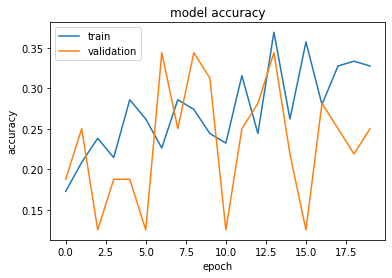

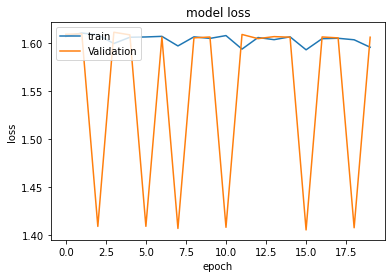

In [ ]:
## Plotting

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
### Number of Parameters 24,419,525
### Base : VGG
### Model CNN's + LSTM
### Result
'''
Model performing very poorly, is underfit and not converging as well.

'''
### Decision + Explanation
'''
Model still not converging will try LSTM.
'''

## 3.3) Conv2D + LSTM Model

In [ ]:
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.layers import BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D

model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(len(sequence_idx),dim_x,dim_y,3)))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(BatchNormalization())
model.add(ConvLSTM2D(128, kernel_size = 3, return_sequences=False))
model.add(BatchNormalization())
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 23, 142, 142, 32)  896       
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 142, 142, 32)  128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 23, 140, 140, 64)  18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 140, 140, 64)  256       
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 138, 138, 128)     885248    
_________________________________________________________________
batch_normalization_2 (Batch (None, 138, 138, 128)     512       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 138, 138, 64)     

In [ ]:
batch_size = 4
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_3.3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5455 - categorical_accuracy: 0.3571Source path =  datasets/Project_data/val ; batch size = 4

Epoch 00001: saving model to model_init_3.3_2021-06-2718_52_23.901543/model-00001-1.54546-0.35714-1.61472-0.18750.h5
21/21 [==============================] - 16s 779ms/step - loss: 1.5455 - categorical_accuracy: 0.3571 - val_loss: 1.6147 - val_categorical_accuracy: 0.1875
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5806 - categorical_accuracy: 0.2262
Epoch 00002: saving model to model_init_3.3_2021-06-2718_52_23.901543/model-00002-1.58056-0.22619-1.63344-0.18750.h5
21/21 [==============================] - 15s 718ms/step - loss: 1.5806 - categorical_accuracy: 0.2262 - val_loss: 1.6334 - val_categorical_accuracy: 0.1875
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.4895 - categorical_accuracy: 0.4405
Epoch 00003: saving model to model_init_3.3_2021-06-2718_52_23.901543/model-00

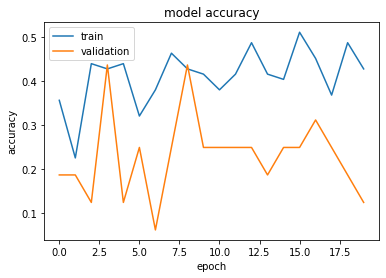

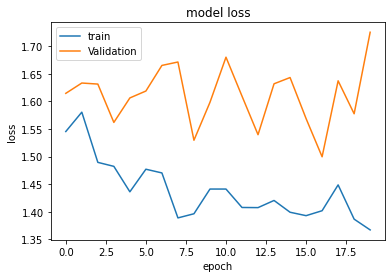

In [ ]:
## Plotting

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
### Number of Parameters 918,533
### Model CNN's + LSTM
### Result
'''
Model accuracy improved but Conv2d + LSTM still not giving good accuracy. 



### Final Conclusion

Conv3d is the best model in terms of accuracy. We will go ahead with this model.  